# Permitted Emissions in Minneapolis (MPCA)

This notebook retrieves the Minnesota Pollution Control Agency's annual statewide permitted emissions for the years 2006 - 2020, cleans the entries, clips the dataset to the extent of this project, and saves the results as a csv file.

**Downloaded Data Info:**

CRS: WGS84 - epsg:4326

Size: 34mb

**Saved Data Info:**

Saved as a CSV with Northing/Easting from UTM 15N:epsg26915

CRS: UTM 15N - epsg:26915
    
Size: 53.6mb

Source: https://www.pca.state.mn.us/air/permitted-facility-air-emissions-data

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects
import requests

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

from pprint import pprint # Pretty Printing
import matplotlib.pyplot as plt # Basic Plotting
import contextily # Base Map Visualization

import warnings
warnings.filterwarnings('ignore') # Ignores some warnings

In [2]:
### Definitions

# Forward or back slashs for filepaths? <- Not sure here. Only know Windows & Linux

if platform == "linux" or platform == "linux2":
    slash = '/'
elif platform == 'win32':
    slash = '\\'

def extract_zip_from_url(url=None):
    '''Extract a zipfile from the internet and unpack it in to it's own folder within working directory.
    Takes a single url (string).'''
    
    if type(url) == str: # Single url
        # Unload zip into the new folder
        response = urllib.request.urlopen(url) # Get a response
        zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
        zip_folder.extractall(path=os.getcwd()) # Extract files
        zip_folder.close() # Close zip object
    else:
        print('Error Extracting: Invalid Input')

In [3]:
### Load Data

if os.path.exists('PointSourceAirEmissionsInventory/MPCA_PointSourceEmissionInventory.xlsx'):
    # Already downloaded
    # Load as DataFrame
    print('''You have downloaded the data but not processed it\n
    It's in an excel spreadsheet so you may need to install the package: openpyxl\n
    It will take a minute or two to read.''')
    mn_emissions = pd.read_excel('PointSourceAirEmissionsInventory/MPCA_PointSourceEmissionInventory.xlsx')
    print('DONE!')
else: # Download
    
    ## AADT for all of Minnesota - Downloaded from MN GeospatialCommons gisdata.mn.gov  (~ 5mb)
    
    print('''Downloading current state data from MPCA (~34 mb)\n
    It is in an excel spreadsheet so you may need to install the package: openpyxl\n
    It will take a minute or two to read.''')
    url = 'https://files.pca.state.mn.us/pub/file_requests/datasets/Air/PointSourceAirEmissionsInventory.zip'
    extract_zip_from_url(url)
    mn_emissions = pd.read_excel('PointSourceAirEmissionsInventory/MPCA_PointSourceEmissionInventory.xlsx') # Load as DataFrame

You have downloaded the data but not processed it

    It's in an excel spreadsheet so you may need to install the package: openpyxl

    It will take a minute or two to read.
DONE!


---

## **Explore the data**

---

In [4]:
mn_emissions.head()

,YEAR,FACILITY_ID,PERMIT_TYPE,FACILITY_NAME,INDUSTRY_TYPE,NAICS_CODE,POLLUTANT,EMISSIONS (TONS),EMISSIONS (LB),COUNTY,ZIP_CODE,LONGITUDE,LATITUDE
0,2006,99000269,R,Central Specialties Inc - Plant 4,Manufacturing,324121,Carbon Monoxide,26.32,52648.0,Portable Source,NaN,NaN,NaN
1,2006,99000269,R,Central Specialties Inc - Plant 4,Manufacturing,324121,Nitrogen Oxides,22.72,45439.0,Portable Source,NaN,NaN,NaN
2,2006,99000269,R,Central Specialties Inc - Plant 4,Manufacturing,324121,PM Primary,66.95,133890.0,Portable Source,NaN,NaN,NaN
3,2006,99000269,R,Central Specialties Inc - Plant 4,Manufacturing,324121,PM10 Primary,17.38,34768.0,Portable Source,NaN,NaN,NaN
4,2006,99000269,R,Central Specialties Inc - Plant 4,Manufacturing,324121,Sulfur Dioxide,11.42,22831.0,Portable Source,NaN,NaN,NaN


In [5]:
# Okay, this is some interesting data... We've got County and year that we can query by, however...

print('County Names:\n')
pprint(np.sort(mn_emissions['COUNTY'].unique())) 

print('Years:\n')
pprint(np.sort(mn_emissions['YEAR'].unique())) 

County Names:

array(['ANOKA', 'Aitkin', 'Anoka', 'BECKER', 'BENTON', 'BLUE EARTH',
       'Becker', 'Beltrami', 'Benton', 'Big Stone', 'Blue Earth', 'Brown',
       'CARVER', 'CLAY', 'CROW WING', 'Carlton', 'Carver', 'Cass',
       'Chippewa', 'Chisago', 'Clay', 'Clearwater', 'Cook', 'Cottonwood',
       'Crow Wing', 'DAKOTA', 'DOUGLAS', 'Dakota', 'Dodge', 'Douglas',
       'FREEBORN', 'Faribault', 'Fillmore', 'Freeborn', 'GOODHUE',
       'GRANT', 'Goodhue', 'Grant', 'HENNEPIN', 'Hennepin', 'Houston',
       'Hubbard', 'ITASCA', 'Isanti', 'Itasca', 'JACKSON', 'Jackson',
       'Kanabec', 'Kandiyohi', 'Kittson', 'Koochiching', 'LAKE',
       'LE SUEUR', 'Lac Qui Parle', 'Lake', 'Lake Of The Woods',
       'Le Sueur', 'Lyon', 'MCLEOD', 'MORRISON', 'MOWER', 'Mahnomen',
       'Marshall', 'Martin', 'Mcleod', 'Meeker', 'Mille Lacs', 'Morrison',
       'Mower', 'Murray', 'Nicollet', 'Nobles', 'Norman', 'Olmsted',
       'Otter Tail', 'PINE', 'PIPESTONE', 'POLK', 'PORTABLE SOURCES',
       

In [6]:
# Some observations:
    # This data spans 2006 - 2020
    # There appears to be both HENNEPIN and Hennepin, etc
    # There are also counties called 
        # "Portable Source", "Portable Sources", and "PORTABLE SOURCES" that I'm a little curious about
        # Last time I did this there weren't any PORTABLE SOURCES... Just the other two


weird_names = ["Portable Source", "Portable Sources", "PORTABLE SOURCES"]

portable_sources = mn_emissions[mn_emissions.COUNTY.isin(weird_names)]

print('Years they exist:\n')
pprint(np.sort(portable_sources['YEAR'].unique())) 

# print('Facility Names:\n')
# pprint(np.sort(portable_sources['FACILITY_NAME'].unique()))

# There's a lot of "portable sources"
# Could use the google API to text search their locations!...?

# TO DO LATER!

Years they exist:

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020])


In [7]:
# Select for relevant Counties (~ 7 county metro)
# Anoka, Carver, Dakota, Hennepin, Ramsey, Scott, Washington
# The capitalization is weird, but everything's spelt correctly!

counties = mn_emissions['COUNTY'].apply(lambda x : x.upper()) # Get all counties, capitalized

focus_counties = ['ANOKA', 'CARVER', 'DAKOTA', 'HENNEPIN', 'RAMSEY', 'SCOTT', 'WASHINGTON'] # Focus of study

good_index = counties.isin(focus_counties) # Getting indices of our data

emissions = mn_emissions[good_index] # Subset data

emissions.shape # 218324 entries

(218324, 13)

---

## **Lat/Lon Correction**

---

In [8]:
### NOTE: As of 10/6/2022, the LATITUDE and LONGITUDE in the downloaded file are flipped

# MPCA was notified 3/18/2022

print('Downloaded:\n', emissions[['LONGITUDE','LATITUDE']].head(1))

correct = emissions.copy(deep=True)

# Flipping Lat/Long

lats = emissions.LONGITUDE.values
lons = emissions.LATITUDE.values

correct.loc[:, 'LONGITUDE'] = lons
correct.loc[:, 'LATITUDE'] = lats

print('Corrected:\n', correct[['LONGITUDE','LATITUDE']].head(1))

emissions = correct

Downloaded:
    LONGITUDE   LATITUDE
7  44.921298 -92.968215
Corrected:
    LONGITUDE   LATITUDE
7 -92.968215  44.921298


---

## **Clean Coordinates**

---

In [9]:
# Are there zeros? 

zero_lat = np.where(emissions.LATITUDE == 0)[0]
zero_lon = np.where(emissions.LONGITUDE == 0)[0]

print(len(zero_lat))
print(len(zero_lon))

# No

0
0


In [10]:
# Are there nans? - YES!

nan_lat = np.isnan(emissions.LATITUDE)
nan_lon = np.isnan(emissions.LONGITUDE)

has_nan = nan_lat + nan_lon

nan_data = emissions[has_nan]

# Who done it?

nan_facilities = nan_data['FACILITY_NAME'].unique()

for facility in np.sort(nan_facilities):
    print(facility)

Aggregate Industries - Nonmetallic
Anchor Block Co - South Plant
Bryan Rock Products Inc - Nonmetallic
Bury & Carlson Inc
Bury & Carlson Inc - Nonmetallic
CS McCrossan Construction Inc
CS McCrossan Inc - Stationary
City of St Paul Asphalt Plant
Doboszenski & Sons Inc
Fischer Mining
Fischer Mining LLC - Nonmetallic
Hardrives Inc - Nonmetallic
Hassan Sand & Gravel Inc
Hassan Sand & Gravel Inc - Nonmetallic
Midwest Asphalt Corp
Midwest Asphalt Corp - Nonmetallic
Midwest Asphalt Services LLC
Pentagon Materials Inc
Pine Bend Paving Inc
Pine Bend Paving Inc - Vermillion Site - NM
Prior Lake Aggregates Inc
Prior Lake Aggregates Inc - Nonmetallic
Saint Paul Department of Public Works/Asphalt Plt
Semple Recycling & Crushing LLC
Semple Recycling & Crushing LLC - NM
Wm Mueller & Sons Inc
Wm Mueller & Sons Inc - Nonmetallic
Xcel Energy - General Office


In [11]:
# That's a lot...

# May have to google these to see for sure where/what they are...

In [12]:
def google_places_to_df(query_type = 'findplace',
                         fields = ['formatted_address', 'name', 'geometry'],
                         text_inputs = ['Hello'],
                         location_bias = None,
                         api = ''):

    ''' This function will take a url to the goole api and convert the response into a geodataframe.
        It does NOT work with a "find place" search
        
    # To Download Data from Google Places API
    # Must create a project on google API Console - https://console.developers.google.com/
    # Enable Google Places API
    # They need a credit card...
    
    # Location Bias should be in lat/lon!
    
    # Base of the url = https://maps.googleapis.com/maps/api/place/details/output?parameters
    '''
    
    if query_type == 'findplace':
        base_url = 'https://maps.googleapis.com/maps/api/place/findplacefromtext/json?'
        
    fields_url = 'fields=' + '%2C'.join(fields)
    inputs_url = '&input=' + '%20'.join(text_inputs) 
    
    if query_type == 'findplace':
        inputs_url += '&inputtype=textquery'
        
    if location_bias is not None:
        low_bounds_url = str(bounds[0])+','+str(bounds[1])
        high_bounds_url = str(bounds[2])+','+str(bounds[3])
        inputs_url += '&locationbias=rectangle:' + low_bounds_url +'|' + high_bounds_url
    
    url = base_url + fields_url + inputs_url + '&key=' + api
    
    response = requests.request("GET", url) # Get request
    
    if query_type == 'findplace':
        results_key = 'candidates'
    else:
        results_key = 'results'
    
    results = response.json()[results_key] # Read request as a dictionary

    df = pd.DataFrame(results) # Convert Dictionary to DataFrame (without correct "geometry" column)
    
    df['Query'] = ' '.join(text_input)
    return df

In [13]:
api = input('Please enter your Google api key')

Please enter your Google api key Nah


In [14]:


if os.path.exists('NAN_Emissions_Search_Results.geojson'): # Already Googled
    
     potential_matches_gdf = gpd.read_file('NAN_Emissions_Search_Results.geojson')

else:
    # Google for all the nans

    # Initialize

    bounds = extent.to_crs('EPSG:4326').total_bounds

    corrected_bounds = [bounds[1], bounds[0], bounds[3], bounds[2]]

    columns = ['formatted_address', 'name', 'geometry']

    potential_matches = pd.DataFrame(columns = columns) # initialize dataframe


    for facility in nan_facilities:
        # Create query
        text_input = facility.split(' ')
        # Remove things that mess up query
        if '&' in text_input:
            text_input.remove('&')
        if '-' in text_input:
            text_input.remove('-')
        if 'NM' in text_input:
            text_input.remove('NM') # MAkes google think New Mexico

        df = google_places_to_df(query_type='findplace', 
                         fields=['formatted_address', 'name', 'geometry'], 
                         text_inputs=text_input,
                         location_bias=corrected_bounds,
                         api=api)

        potential_matches = pd.concat([potential_matches, df], ignore_index = True)

    # Now let's put them into a geodataframe.

    # Get lat/longs for geometry column

    potential_matches['x'] = None # Initialize column for Longitude
    potential_matches['y'] = None # Initialize column for Latitude

    for i, row in potential_matches.iterrows(): # Iterate through rows
        potential_matches.loc[i,'x'] = row.geometry['location']['lng'] # Get info
        potential_matches.loc[i,'y'] = row.geometry['location']['lat']

    # Convert to GeoDataFrame

    potential_matches_gdf = gpd.GeoDataFrame(potential_matches.drop(columns='geometry'),
                           geometry = gpd.points_from_xy(potential_matches['x'], potential_matches['y']),
                           crs = 'EPSG:4326')

In [15]:
potential_matches_gdf

,formatted_address,name,Query,x,y,geometry
0,"14060 Jonathan Carver Pkwy, Carver, MN 55315, ...",William Mueller & Sons,Wm Mueller Sons Inc Nonmetallic,-93.64829109999999,44.7509424,POINT (-93.64829 44.75094)
1,"831 Park Ave, Hamburg, MN 55339, United States",William Mueller & Sons,Wm Mueller Sons Inc Nonmetallic,-93.95917179999999,44.7321835,POINT (-93.95917 44.73218)
2,"201 W 121st St, Burnsville, MN 55337, United S...",Bury & Carlson Inc,Bury Carlson Inc Nonmetallic,-93.2827985,44.7866904,POINT (-93.28280 44.78669)
3,"16500 Fischer Ave, Hastings, MN 55033, United ...",Pine Bend Paving Inc,Pine Bend Paving Inc Vermillion Site -,-92.97560279999999,44.7095306,POINT (-92.97560 44.70953)
4,"400 W 61st St, Minneapolis, MN 55419, United S...",Aggregate Industries Minneapolis,Aggregate Industries Nonmetallic,-93.2848927,44.8929952,POINT (-93.28489 44.89300)
5,"15255 Johnny Cake Ridge Rd, Apple Valley, MN 5...",Fischer Scale Shack,Fischer Mining LLC Nonmetallic,-93.1870433,44.7306597,POINT (-93.18704 44.73066)
6,"14698 Galaxie Ave, Apple Valley, MN 55124, Uni...",AVR Inc Office,Fischer Mining LLC Nonmetallic,-93.2068405,44.7357711,POINT (-93.20684 44.73577)
7,"7865 Jefferson Hwy, Maple Grove, MN 55369, Uni...",C.S. Mccrossan Construction Inc,CS McCrossan Inc Stationary,-93.40602779999999,45.0975337,POINT (-93.40603 45.09753)
8,"9633 85th Ave N, Maple Grove, MN 55369, United...",Conquest Bindery,CS McCrossan Inc Stationary,-93.4039176,45.1084013,POINT (-93.40392 45.10840)
9,"401 Nicollet Mall, Minneapolis, MN 55401, Unit...",Xcel Energy,Xcel Energy General Office,-93.26991629999999,44.9794554,POINT (-93.26992 44.97946)


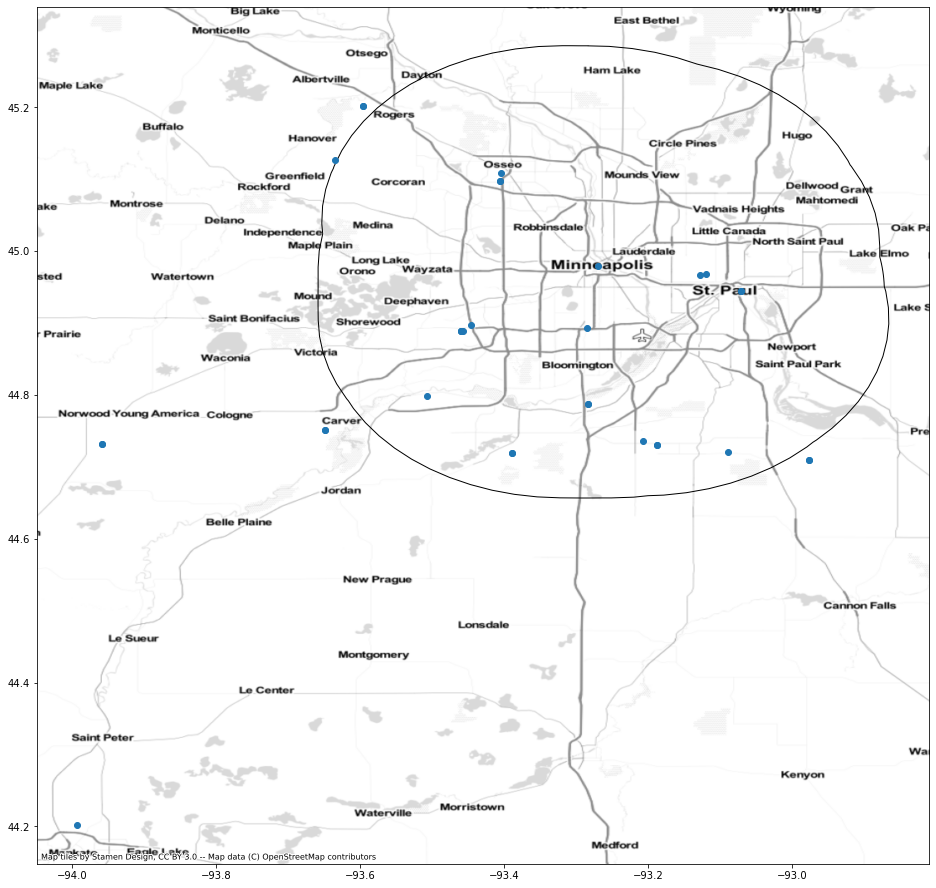

In [16]:
# Let's plot them

f, ax = plt.subplots(1,1, figsize = (16,16))

extent = gpd.read_file('Data/study_extent.geojson') # Load Extent
extent.to_crs('EPSG:4326').plot(ax = ax, edgecolor='black', facecolor='none')

potential_matches_gdf.plot(ax = ax)

contextily.add_basemap(ax = ax, 
                       crs = potential_matches_gdf.crs, 
                       source = contextily.providers.Stamen.TonerLite
                      )

In [17]:
# Hmm Many of these appear to be in our study area

# I'm gonna save it for later...

potential_matches_gdf.to_file('NAN_Emissions_Search_Results.geojson')

In [18]:
# Corrected data?

corrected = emissions[np.invert(has_nan)]

---

## **Spatialize**

---

In [19]:
## Spatialize

emissions_geo = gpd.GeoDataFrame(corrected, geometry=gpd.points_from_xy\
                            (corrected.LONGITUDE, corrected.LATITUDE)
                               ) # Points from xy

emissions_geo.crs = 'EPSG:4326' # Initialize CRS

emissions_geo = emissions_geo.to_crs('EPSG:26915') # Localize CRS

# Clip to extent - This shaves off 42,602 entries (

extent = gpd.read_file('Data/study_extent.geojson') # Load Extent
    
emissions_geo_clipped = gpd.clip(emissions_geo, extent) # Clip

emissions_geo_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 194326 entries, 125759 to 477554
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   YEAR              194326 non-null  int64   
 1   FACILITY_ID       194326 non-null  int64   
 2   PERMIT_TYPE       194326 non-null  object  
 3   FACILITY_NAME     194326 non-null  object  
 4   INDUSTRY_TYPE     194326 non-null  object  
 5   NAICS_CODE        194326 non-null  int64   
 6   POLLUTANT         194326 non-null  object  
 7   EMISSIONS (TONS)  194326 non-null  float64 
 8   EMISSIONS (LB)    194326 non-null  float64 
 9   COUNTY            194326 non-null  object  
 10  ZIP_CODE          194326 non-null  object  
 11  LONGITUDE         194326 non-null  float64 
 12  LATITUDE          194326 non-null  float64 
 13  geometry          194326 non-null  geometry
dtypes: float64(4), geometry(1), int64(3), object(6)
memory usage: 22.2+ MB


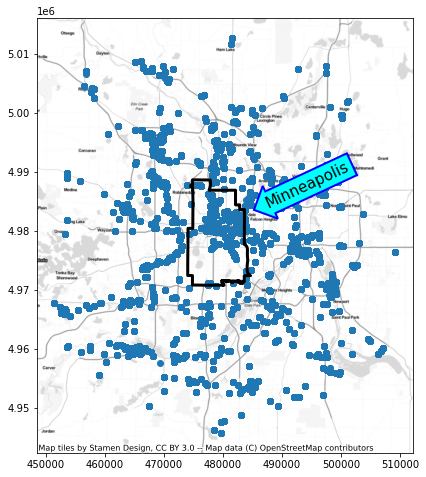

In [20]:
### Check points

# Load Minneapolis Boundary

mpls = gpd.read_file('Data/mpls_boundary.geojson')

f, ax = plt.subplots(1,1,figsize = (8,8))

emissions_geo_clipped.plot(ax = ax)

mpls.plot(ax = ax,
         edgecolor='black', facecolor='none',
         linewidth=3,
         zorder = 2,
         legend = True)

# Annotate

for i, row in mpls.iterrows():
    
    # Get important locations
    center = row.geometry.representative_point().coords[0]
    bounds = emissions_geo_clipped.total_bounds
    top_right = (bounds[2], bounds[3])
    text_spot = tuple(map(lambda i, j: i - j, top_right, (15000, 25000)))
    
    # Make text within an arrow
    ax.text(text_spot[0], text_spot[1], 
            row.CTU_NAME, ha="center", 
            va="center", rotation=25, size=15, 
            bbox=dict(boxstyle="larrow,pad=0.3", fc="cyan", ec="b", lw=2))
    
    # ax.annotate(text=row.CTU_NAME, 
    #             xy = row.geometry.representative_point().coords[0], 
    #             xytext = text_spot, # Placement
    #             arrowprops = dict(width=.7, arrowstyle='simple')
    #             ha='center', size = 32, weight = 'bold')

contextily.add_basemap(ax = ax, 
                       crs = mpls.crs, 
                       source = contextily.providers.Stamen.TonerLite
                      )

In [21]:
# Wow... You can already see some point pattern there

---

## Focus & Save

---

In [22]:
# Showing columns

emissions_geo_clipped.columns

Index(['YEAR', 'FACILITY_ID', 'PERMIT_TYPE', 'FACILITY_NAME', 'INDUSTRY_TYPE',
       'NAICS_CODE', 'POLLUTANT', 'EMISSIONS (TONS)', 'EMISSIONS (LB)',
       'COUNTY', 'ZIP_CODE', 'LONGITUDE', 'LATITUDE', 'geometry'],
      dtype='object')

In [23]:
# Focus the data to save as a csv
    # Note: This dataset doesn't contain pollutant groups like the one in 2019

focus = emissions_geo_clipped[['FACILITY_NAME', 'FACILITY_ID', 'PERMIT_TYPE', 'INDUSTRY_TYPE','NAICS_CODE', 'YEAR', 
                        'POLLUTANT', 'EMISSIONS (LB)', 'EMISSIONS (TONS)']] # Select relevant columns

                    # Removed COUNTY, ZIP_CODE, LONGITUDE, LATITUDE, geometry
                    # Will replace long/lat with UTM 15N northing/easting

focus = focus.rename(columns={'EMISSIONS (LB)':'LBS_EMITTED','EMISSIONS (TONS)':'TONS_EMITTED'}) # Easier names

focus['EASTING'] = emissions_geo_clipped.geometry.x
focus['NORTHING'] = emissions_geo_clipped.geometry.y

print(focus.info()) # Show column names/types/etc.
focus.head() # Look at first entries

focus.to_csv('Data/emissions.csv', index_label='id') # Saving as emissions.csv

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194326 entries, 125759 to 477554
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   FACILITY_NAME  194326 non-null  object 
 1   FACILITY_ID    194326 non-null  int64  
 2   PERMIT_TYPE    194326 non-null  object 
 3   INDUSTRY_TYPE  194326 non-null  object 
 4   NAICS_CODE     194326 non-null  int64  
 5   YEAR           194326 non-null  int64  
 6   POLLUTANT      194326 non-null  object 
 7   LBS_EMITTED    194326 non-null  float64
 8   TONS_EMITTED   194326 non-null  float64
 9   EASTING        194326 non-null  float64
 10  NORTHING       194326 non-null  float64
dtypes: float64(4), int64(3), object(4)
memory usage: 17.8+ MB
None
